# paramhist
Plot histogram of image parameters for gamma ray showers and hadronic showers with the goal of reproducing Fig 7 in Fegan 1997 
https://iopscience.iop.org/article/10.1088/0954-3899/23/9/004/pdf

Author: Nik Korzoun

# Imports

In [32]:
# imports
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.dates import DateFormatter
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

# for BDT
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# Read Data
1 corresponds to gamma-rays and 2 corresponds to cosmic-rays

e.g. df1 is the dataframe with gamma-ray data and df2 is the dataframe with cosmic-ray data

## Data files

In [33]:
# read data
# files = [
#     "../data/PH_Markarian_onskyph11.5pe__20240317_053053_631.pcapng.root.no_shift.csv"
# ]

import glob
# files=glob.glob("../October2024/d20241101/ph/cleaned/*.csv")
# files=glob.glob("../October2024/d20241101/ph/cleaned/*.corrected.csv")

files1 = glob.glob("../October2024/d20241101/ph/cleaned/*.csv")
files2 = glob.glob("../October2024/d20241031/ph/cleaned/*.csv")
files3 = glob.glob("../October2024/d20241030/ph/cleaned/*.csv")

files=files1+files2+files3
files=[f for f in files if "Crab" in f]
# files=[f for f in files if "Boomerang" in f]
files=[f for f in files if "corrected" in f]

# files = glob.glob("../March2024/*.root.no_shift.csv")
# files = glob.glob("../data/*.root.csv")
# files.remove("../data/arraytest.root.csv")
files = sorted(files)

len(files)

# files = files[:14]

for f in files:
    print(f)

buffer=0
list=[]
for f in files:
    temp = pd.read_csv(f)
    temp["File"]=f[36:-16]
    temp["In-file-Index"]=temp["Event"]
    temp["Event"]=temp["Event"]+buffer
    buffer+=len(temp)
    list.append(temp)

df = pd.concat(list, ignore_index=True)
# df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

../October2024/d20241030/ph/cleaned/Pause_onsky_Crabph0pe_ima0pe__20241030_080321_671.pcapng.root.corrected.csv
../October2024/d20241030/ph/cleaned/Pause_onsky_Crabph0pe_ima0pe__20241030_081322_328.pcapng.root.corrected.csv
../October2024/d20241030/ph/cleaned/Pause_onsky_Crabph0pe_ima0pe__20241030_082323_091.pcapng.root.corrected.csv
../October2024/d20241030/ph/cleaned/Pause_onsky_Crabph0pe_ima0pe__20241030_083323_976.pcapng.root.corrected.csv
../October2024/d20241030/ph/cleaned/Pause_onsky_Crabph0pe_ima0pe__20241030_084324_609.pcapng.root.corrected.csv
../October2024/d20241030/ph/cleaned/Pause_onsky_Crabph0pe_ima0pe__20241030_085325_535.pcapng.root.corrected.csv
../October2024/d20241030/ph/cleaned/Pause_onsky_Crabph0pe_ima0pe__20241030_090326_131.pcapng.root.corrected.csv
../October2024/d20241030/ph/cleaned/Pause_onsky_Crabph0pe_ima0pe__20241030_091326_986.pcapng.root.corrected.csv
../October2024/d20241030/ph/cleaned/Pause_onsky_Crabph0pe_ima0pe__20241030_092327_698.pcapng.root.correc

## Cleaning data

In [34]:
# remove nans
array=df.dropna(subset=["Length", "Width","Miss","Distance","Azwidth","Alpha"])
array=array[array["Width"]>0]

# array=array[array["StdX"]>1]
# array=array[array["StdY"]>1]
# array=array[array["MeanX"]<1]
# array=array[array["MeanY"]<1]
# array=array[array["MeanX"]>-1]
# array=array[array["MeanY"]>-1]
# array=array[array["Size"]>1e3]

# array=array[array["Length"]>4*array["Width"]]
# array=array[array["Length"]>4]
# array=array[array["Size"]>1e4]
# array=array[array["Distance"]<3.5]

# cut by number of telescopes
minTel=0
array = array.groupby('Event', group_keys=False).filter(lambda x: len(x) > (minTel-1))

# array.head()
# with pd.option_context('display.max_rows', None):
#   display(array)

# array.head(50)

In [35]:
# array=array[array['Telescope']!=1]
# array[array["File"]=='20240317_051052_531.pcapng.r'].head(50)

In [36]:
# array=array[array["Width"]>.13]
# array=array[array["Width"]<.15]
# array=array[array["Length"]<1.3]
# array=array[array["Distance"]>3]

# array.head(180)

### remove duplicates

In [37]:
# array=array.drop(columns=["Telescope","Event", "In-file-Index"])
# array.duplicated().value_counts()
array=array.drop_duplicates(subset=array.drop(["Telescope","Event", "File"], axis=1))

In [38]:
#reindex events
array['Event']=range(1,len(array)+1)

In [39]:
array.describe()

,Event,Telescope,Timestamp,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,Miss,Distance,Azwidth,Alpha,In-file-Index
count,15638.00000,15638.000000,1.563800e+04,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,1.563800e+04,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000
mean,7819.50000,2.215501,1.730354e+09,-0.095991,0.336551,-0.088830,0.332561,180.533722,5.323312e+03,0.417558,0.236738,2.306881,3.690166,0.334151,43.389064,1050.839302
std,4514.44609,0.763016,8.249240e+04,2.816808,0.234980,2.773514,0.215461,138.414041,2.627050e+04,0.270845,0.147464,1.540203,1.423270,0.240770,25.912934,1679.930989
min,1.00000,1.000000,1.730275e+09,-8.085430,0.047341,-5.262730,0.041751,0.000000,4.600000e+01,0.149355,0.041465,0.000161,0.050020,0.063338,0.003342,1.000000
25%,3910.25000,2.000000,1.730282e+09,-2.448205,0.217280,-2.479938,0.216145,44.457636,8.360000e+02,0.269300,0.157503,0.976937,2.658572,0.213538,20.233050,289.000000
50%,7819.50000,2.000000,1.730291e+09,-0.237781,0.283423,-0.218464,0.281957,270.136309,1.600000e+03,0.356093,0.208653,2.111257,3.837073,0.278624,43.047688,626.000000
75%,11728.75000,3.000000,1.730452e+09,2.292947,0.384607,2.266271,0.382621,316.014757,3.533000e+03,0.473712,0.267770,3.505314,4.748880,0.378401,65.634571,1084.000000
max,15638.00000,3.000000,1.730463e+09,5.323483,4.111078,5.008919,3.248794,360.000000,1.426572e+06,4.192839,2.464071,7.987504,8.673799,3.511350,89.999522,15846.000000


In [40]:
array.head(10)

,Event,Telescope,Timestamp,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,Miss,Distance,Azwidth,Alpha,File,In-file-Index
3,1,1,1.730275e+09,1.965870,0.235632,-2.562594,0.225965,39.154074,913.0,0.253577,0.205625,3.228432,3.229788,0.253540,88.339200,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,2
13,2,2,1.730275e+09,-4.206652,0.317286,-2.725609,0.270254,32.830000,1861.0,0.346955,0.230934,0.009653,5.012471,0.230934,0.110342,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,5
28,3,2,1.730275e+09,3.620467,0.204921,1.589619,0.257982,63.410341,1111.0,0.273433,0.183798,2.526039,3.954070,0.224740,39.705757,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,10
34,4,2,1.730275e+09,-0.356136,0.252120,-3.519473,0.210709,24.219630,1396.0,0.261585,0.198837,3.063588,3.537446,0.247397,60.002272,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,12
70,5,2,1.730275e+09,1.090208,0.259270,4.239082,0.419499,272.536612,6819.0,0.419754,0.258857,1.276752,4.377027,0.276219,16.959390,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,24
76,6,2,1.730275e+09,2.351357,0.230739,0.441939,0.217766,317.952557,867.0,0.280371,0.148509,1.902991,2.392528,0.240484,52.692033,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,26
85,7,2,1.730275e+09,3.855761,0.235063,-3.134591,0.149199,352.861030,731.0,0.236179,0.147426,2.631110,4.969160,0.176860,31.970866,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,29
87,8,1,1.730275e+09,-2.209192,0.148426,-0.556581,0.224393,286.368544,632.0,0.230274,0.139126,2.276504,2.278226,0.230164,87.772205,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,30
96,9,1,1.730275e+09,0.383854,0.453220,2.007174,0.287862,10.101003,3699.0,0.457629,0.280799,1.908741,2.043549,0.439050,69.072413,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,33
100,10,2,1.730275e+09,-2.632621,0.457048,-1.668092,0.496156,311.678845,7487.0,0.623435,0.257667,3.075468,3.116605,0.616620,80.680482,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,34


In [41]:
array.describe()

,Event,Telescope,Timestamp,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,Miss,Distance,Azwidth,Alpha,In-file-Index
count,15638.00000,15638.000000,1.563800e+04,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,1.563800e+04,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000,15638.000000
mean,7819.50000,2.215501,1.730354e+09,-0.095991,0.336551,-0.088830,0.332561,180.533722,5.323312e+03,0.417558,0.236738,2.306881,3.690166,0.334151,43.389064,1050.839302
std,4514.44609,0.763016,8.249240e+04,2.816808,0.234980,2.773514,0.215461,138.414041,2.627050e+04,0.270845,0.147464,1.540203,1.423270,0.240770,25.912934,1679.930989
min,1.00000,1.000000,1.730275e+09,-8.085430,0.047341,-5.262730,0.041751,0.000000,4.600000e+01,0.149355,0.041465,0.000161,0.050020,0.063338,0.003342,1.000000
25%,3910.25000,2.000000,1.730282e+09,-2.448205,0.217280,-2.479938,0.216145,44.457636,8.360000e+02,0.269300,0.157503,0.976937,2.658572,0.213538,20.233050,289.000000
50%,7819.50000,2.000000,1.730291e+09,-0.237781,0.283423,-0.218464,0.281957,270.136309,1.600000e+03,0.356093,0.208653,2.111257,3.837073,0.278624,43.047688,626.000000
75%,11728.75000,3.000000,1.730452e+09,2.292947,0.384607,2.266271,0.382621,316.014757,3.533000e+03,0.473712,0.267770,3.505314,4.748880,0.378401,65.634571,1084.000000
max,15638.00000,3.000000,1.730463e+09,5.323483,4.111078,5.008919,3.248794,360.000000,1.426572e+06,4.192839,2.464071,7.987504,8.673799,3.511350,89.999522,15846.000000


# Time-Series

In [42]:
# convert to utc
array.Timestamp=pd.to_datetime(array.Timestamp,unit='s',origin='unix',utc=True)

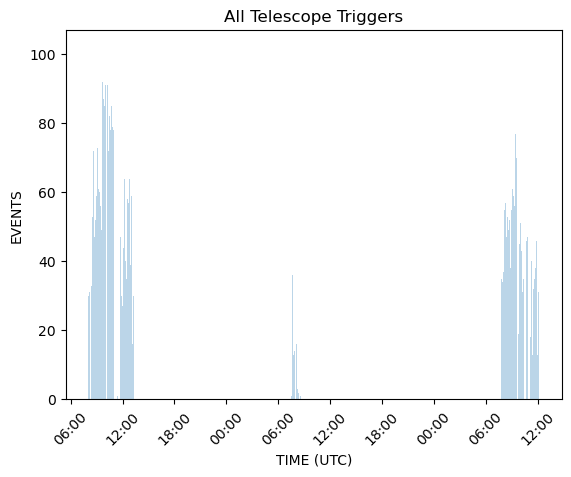

In [43]:
fig, ax = plt.subplots()
plt.title('All Telescope Triggers')
plt.xlabel('TIME (UTC)')
plt.ylabel('EVENTS')
#100 second bins
time_delta=max(array.Timestamp)-min(array.Timestamp)
b=int(time_delta.total_seconds()/100)
ax.hist(array.Timestamp, alpha=0.3, bins=b);
ax.tick_params(axis='x',labelrotation=45)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

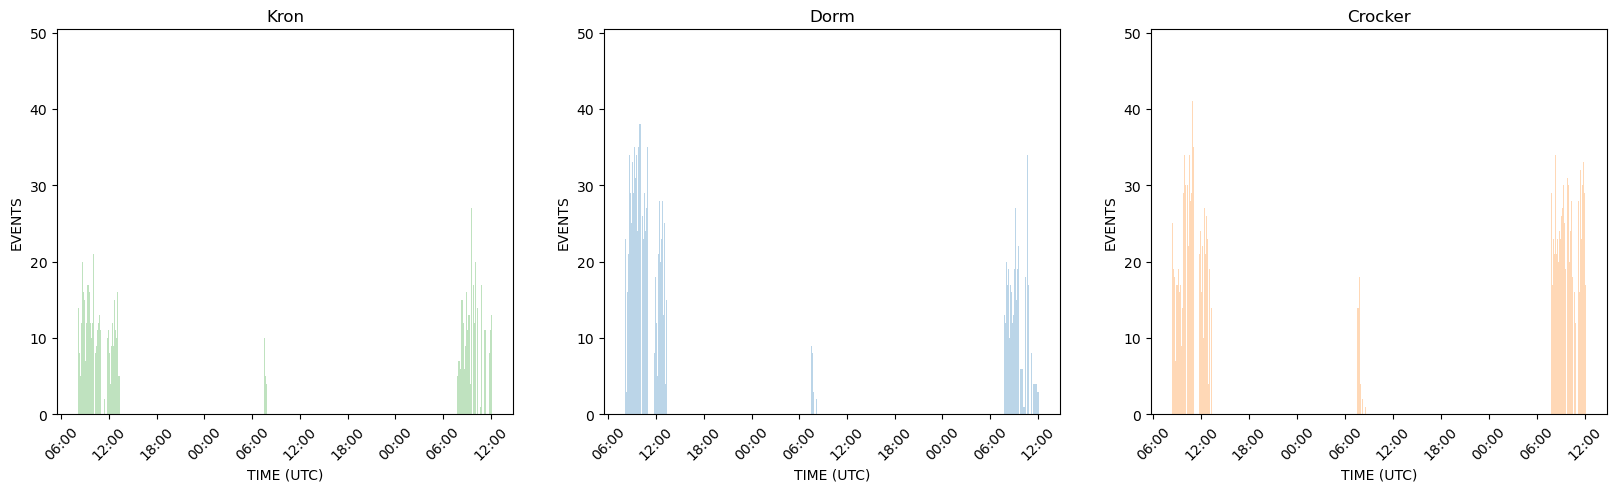

In [44]:
fig, axs = plt.subplots(1,3,figsize=(20,5),sharey=True)

telName = {
  1: "Kron",
  2: "Dorm",
  3: "Crocker"
}

time_delta=max(array.Timestamp)-min(array.Timestamp)
#100 second bins
b=int(time_delta.total_seconds()/100)

colormap = iter(cm.tab10(np.linspace(0, 1, 10)))
for t in [2,3,1]:#range(3,0,-1):
    c=next(colormap)
    # filter by telescope
    telescope = array[array["Telescope"].values == t]
    axs[t-1].hist(telescope.Timestamp, color=c, alpha=0.3, bins=b, label=telName[t]+" (N={:.0f})".format(len(telescope)));
    axs[t-1].tick_params(axis='x',labelrotation=45)
    axs[t-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    axs[t-1].set(title=(telName[t]))

for ax in axs.flat:
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.set(xlabel='TIME (UTC)',ylabel='EVENTS')
    


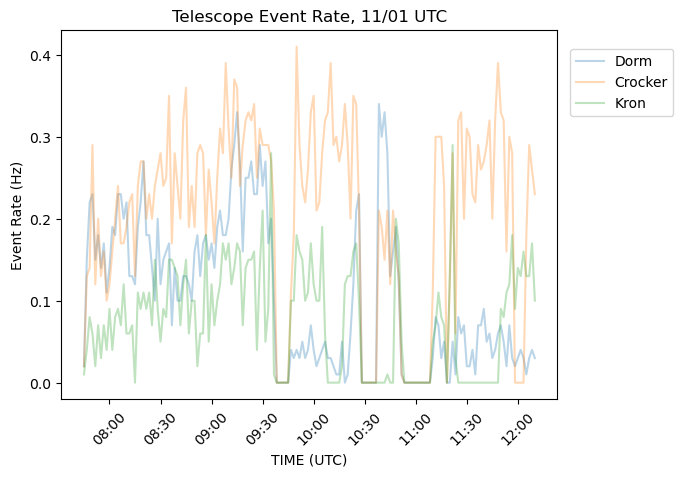

In [45]:
fig, ax = plt.subplots()

telName = {
  1: "Kron",
  2: "Dorm",
  3: "Crocker"
}

ax.set(title='Telescope Event Rate, 11/01 UTC')

# 11/01 UTC
t_start=1730444400
# t_start=1730358000
colormap = iter(cm.tab10(np.linspace(0, 1, 10)))
for t in [2,3,1]:#range(3,0,-1):
    c=next(colormap)
    # filter by telescope
    telescope = array[(array["Telescope"].values == t) & (array.Timestamp > pd.to_datetime(t_start,unit='s',origin='unix',utc=True))]
    event_rate = telescope.resample('100s',on='Timestamp').size()/100
    ax.plot(event_rate, color=c, alpha=0.3, label=telName[t]);
    ax.tick_params(axis='x',labelrotation=45)
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))


ax.yaxis.set_tick_params(labelbottom=True)
ax.set(xlabel='TIME (UTC)',ylabel='Event Rate (Hz)')
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,loc=(1,1),bbox_to_anchor=(0.92, 0.7))


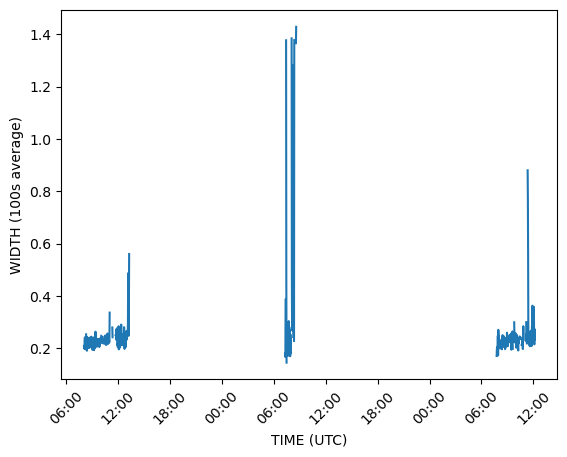

In [46]:
fig, ax = plt.subplots()
plt.xlabel('TIME (UTC)')
plt.ylabel('WIDTH (100s average)')
#100 second bins
time_delta=max(array.Timestamp)-min(array.Timestamp)
b=np.arange(0,int(time_delta.total_seconds()),100)
group=array[['Width']]
group.index=array.Timestamp
group=group.resample("100s").mean()
ax.plot(group.index,group.Width);
ax.tick_params(axis='x',labelrotation=45)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

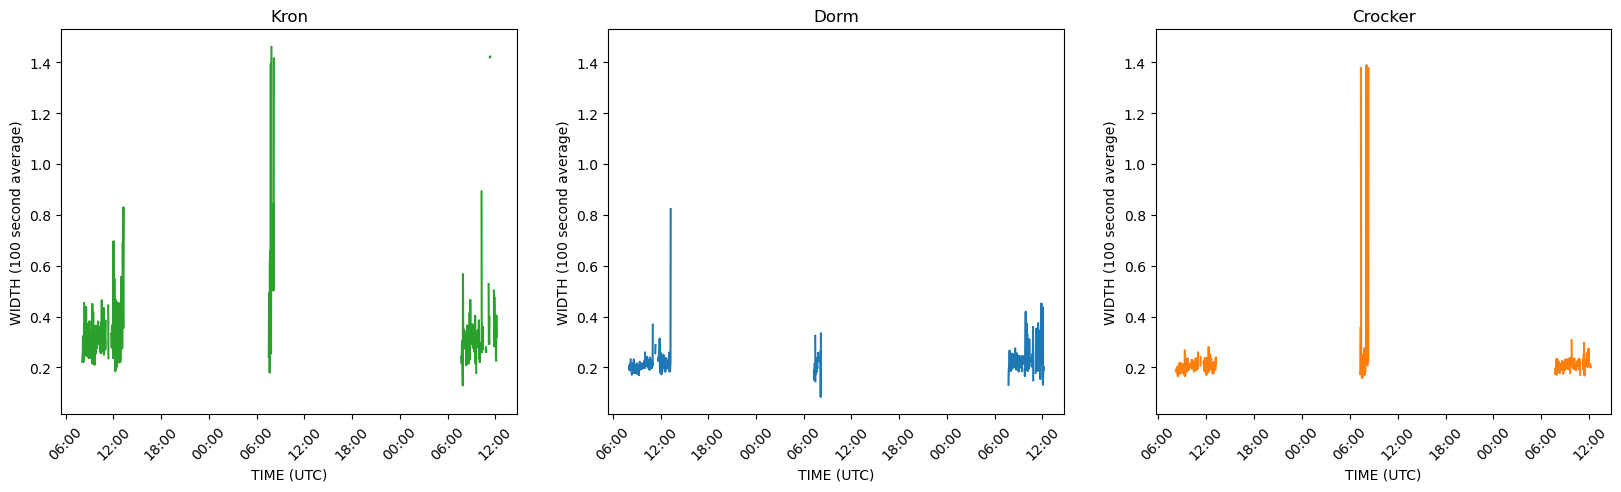

In [47]:
fig, axs = plt.subplots(1,3,figsize=(20,5),sharey=True)

telName = {
  1: "Kron",
  2: "Dorm",
  3: "Crocker"
}

time_delta=max(array.Timestamp)-min(array.Timestamp)
#100 second bins
b=int(time_delta.total_seconds()/100)

colormap = iter(cm.tab10(np.linspace(0, 1, 10)))
for t in [2,3,1]:#range(3,0,-1):
    c=next(colormap)
    # filter by telescope
    telescope = array[array["Telescope"].values == t]
    group=telescope[['Width']]
    group.index=telescope.Timestamp
    group=group.resample("100s").mean()
    axs[t-1].plot(group.index,group.Width,color=c);
    axs[t-1].tick_params(axis='x',labelrotation=45)
    axs[t-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    axs[t-1].set(title=(telName[t]))


for ax in axs.flat:
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.set(xlabel='TIME (UTC)',ylabel='WIDTH (100 second average)')

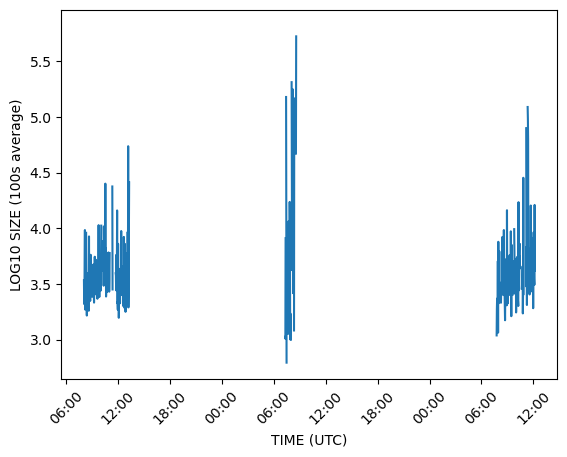

In [48]:
fig, ax = plt.subplots()
plt.xlabel('TIME (UTC)')
plt.ylabel('LOG10 SIZE (100s average)')
#100 second bins
time_delta=max(array.Timestamp)-min(array.Timestamp)
b=np.arange(0,int(time_delta.total_seconds()),100)
group=array[['Size']]
group.index=array.Timestamp
group=group.resample("100s").mean()
ax.plot(group.index,np.log10(group.Size));
ax.tick_params(axis='x',labelrotation=45)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

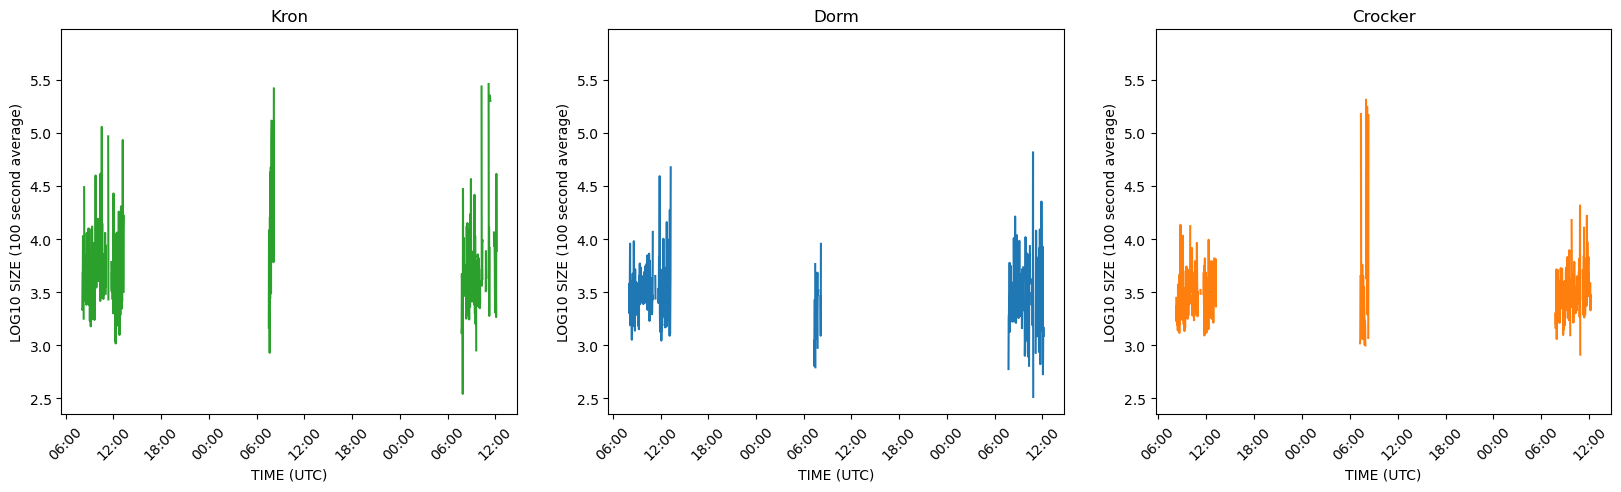

In [49]:
fig, axs = plt.subplots(1,3,figsize=(20,5),sharey=True)

telName = {
  1: "Kron",
  2: "Dorm",
  3: "Crocker"
}

time_delta=max(array.Timestamp)-min(array.Timestamp)
#100 second bins
b=int(time_delta.total_seconds()/100)

colormap = iter(cm.tab10(np.linspace(0, 1, 10)))
for t in [2,3,1]:#range(3,0,-1):
    c=next(colormap)
    # filter by telescope
    telescope = array[array["Telescope"].values == t]
    group=telescope[['Size']]
    group.index=telescope.Timestamp
    group=group.resample("100s").mean()
    axs[t-1].plot(group.index,np.log10(group.Size),color=c);
    axs[t-1].tick_params(axis='x',labelrotation=45)
    axs[t-1].xaxis.set_major_formatter(DateFormatter('%H:%M'))
    axs[t-1].set(title=(telName[t]))
    


for ax in axs.flat:
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.set(xlabel='TIME (UTC)',ylabel='LOG10 SIZE (100 second average)')

# Image Parameter Distributions

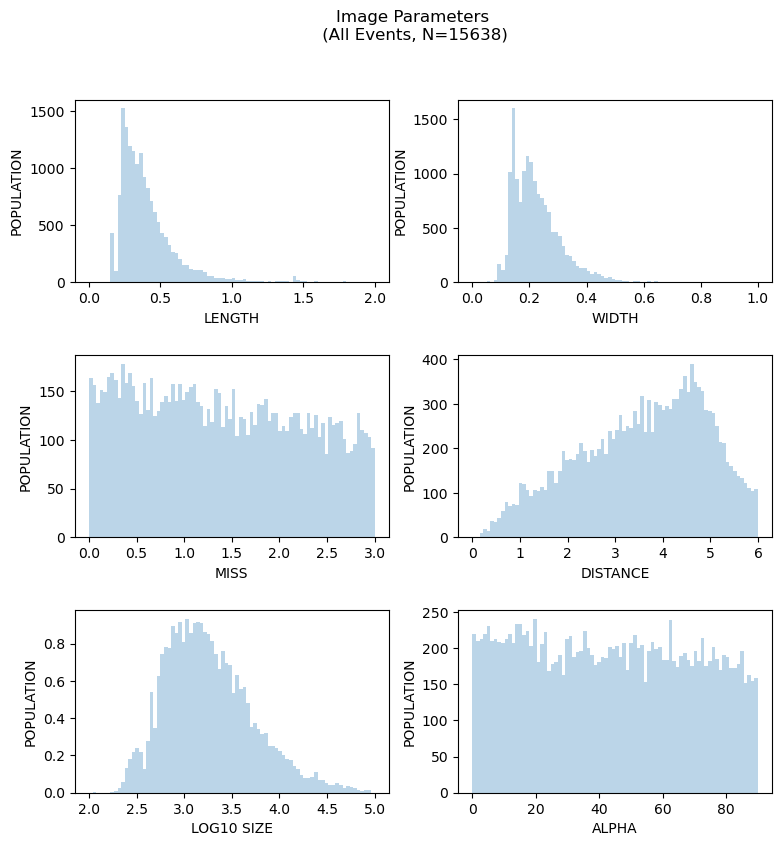

In [50]:
fig, axs = plt.subplots(3,2, figsize=(9,9))

# select subset of showers which are nearby
# array = array[np.hypot(array["TrueXcore"].values,array["TrueYcore"].values) < 200]

# cut showers by distance
# array = array[array["Distance"].values < 3]

# cut showers by width
# array = array[array["Width"].values < 0.2]

# cut showers by alpha
# array = array[array["Alpha"].values < 0.3]

# cut showers by size
# array = array[array["Size"].values > 200]

# cut by number of telescopes
# minTel=0
# array = array.groupby('Event', group_keys=False).filter(lambda x: len(x) > (minTel-1))

# filter by telescope
# array = array[array["Telescope"].values == 3]

fig.suptitle('Image Parameters'+'\n (All Events, N={:.0f})'.format(len(array)))
a=0.3
b=80
axs[0,0].hist(array.loc[:,"Length"], alpha=a, bins=b, range=(0,2))
axs[0,0].set(xlabel='LENGTH')
axs[0,1].hist(array.loc[:,"Width"], alpha=a, bins=b, range=(0,1))
axs[0,1].set(xlabel='WIDTH')
axs[1,0].hist(array.loc[:,"Miss"], alpha=a, bins=b, range=(0,3))
axs[1,0].set(xlabel='MISS')
axs[1,1].hist(array.loc[:,"Distance"], alpha=a, bins=b, range=(0,6))
axs[1,1].set(xlabel='DISTANCE')
# axs[2,0].hist(array.loc[:,"Azwidth"], alpha=a, bins=b, range=(0,1))
# axs[2,0].set(xlabel='AZWIDTH')
axs[2,0].hist(np.log10(array.loc[:,"Size"]), alpha=a, bins=b, range=(2,5),density=True)
axs[2,0].set(xlabel='LOG10 SIZE')
# axs[2,0].hist(sims.loc[:,"Size"], alpha=a, bins=b, range=(0,1e3),color='k',density=True)
# axs[2,0].set(xlabel='SIZE')
axs[2,1].hist(array.loc[:,"Alpha"], alpha=a, bins=b, range=(0,90))
axs[2,1].set(xlabel='ALPHA')

for ax in axs.flat:
    ax.set(ylabel='POPULATION')

plt.subplots_adjust(hspace=0.4,wspace=0.22)
# fig.legend(loc=(0.45,0.9))

# size
# fig,axs = plt.subplots()
# plt.xlabel('SIZE')
# plt.ylabel('POPULATION')
# axs.hist(array.loc[:,"Size"], alpha=0.3, bins=80,range=(0,1e3));

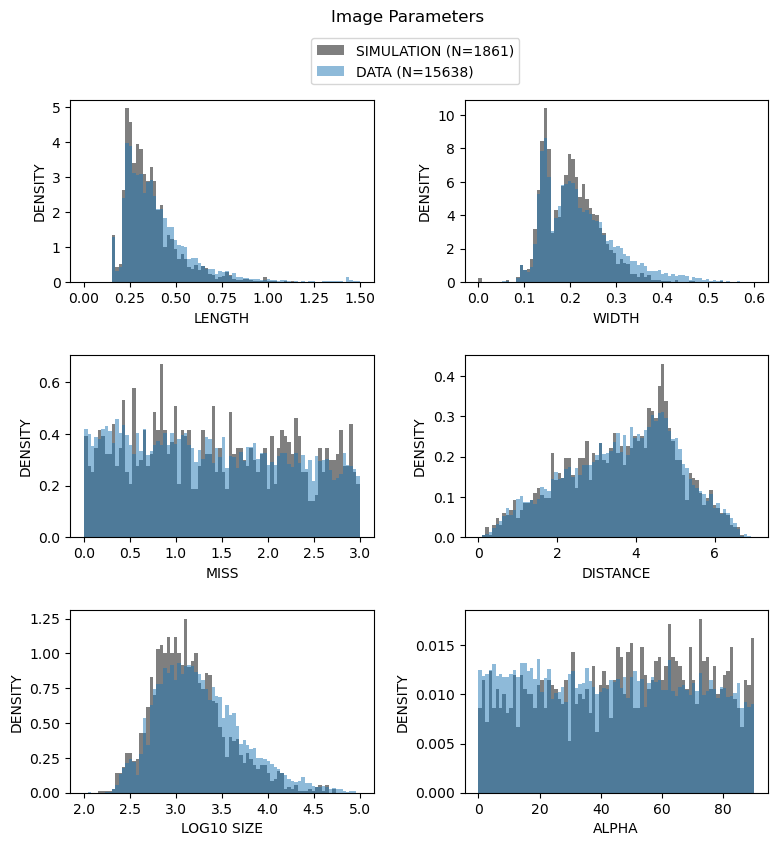

In [51]:
fig, axs = plt.subplots(3,2, figsize=(9,9))

# select subset of showers which are nearby
# array = array[np.hypot(array["TrueXcore"].values,array["TrueYcore"].values) < 200]

# cut showers by distance
# array = array[array["Distance"].values < 3]

# cut showers by width
# array = array[array["Width"].values > 0.15]

# cut showers by alpha
# array = array[array["Alpha"].values < 0.3]

# cut showers by size
# array = array[array["Size"].values > 400]

# cut by number of telescopes
# minTel=0
# array = array.groupby('Event', group_keys=False).filter(lambda x: len(x) > (minTel-1))

# filter by telescope
# array = array[array["Telescope"].values != 1]

fig.suptitle('Image Parameters')
a=0.5
b=80

# # #
# SIMS (PROTON)
# # #
# simfiles = glob.glob("tmp/**/_merged.csv",recursive=True)
# simfiles = sorted(simfiles[:-1]) #exclude gamma
# combined_df = pd.DataFrame()
# for csv_file in simfiles:
#     sim_df = pd.read_csv(csv_file)
#     combined_df = pd.concat([combined_df, sim_df])
combined_df=pd.read_csv("../../corsika/data/lick2024/MRK421-sim-proton/data/_merged.10xSig.csv")
sims=combined_df.dropna(subset=["Length", "Width","Miss","Distance","Azwidth","Alpha"])
sims=sims[sims["Width"]>0]
sims = sims.groupby('Event', group_keys=False).filter(lambda x: len(x) > (minTel-1))

###
# CUTS
###

# array = array[array["Size"].values >= 450]
# sims = sims[sims["Size"].values >= 450]
# array = array[array["Distance"].values < 4]
# sims = sims[sims["Distance"].values < 4]

axs[0,0].hist(sims.loc[:,"Length"], alpha=a, bins=b, range=(0,1.5),color='k',density=True)
axs[0,0].set(xlabel='LENGTH')
axs[0,1].hist(sims.loc[:,"Width"], alpha=a, bins=b, range=(0,0.6),color='k',density=True)
axs[0,1].set(xlabel='WIDTH')
axs[1,0].hist(sims.loc[:,"Miss"], alpha=a, bins=b, range=(0,3),color='k',density=True)
axs[1,0].set(xlabel='MISS')
axs[1,1].hist(sims.loc[:,"Distance"], alpha=a, bins=b, range=(0,7),color='k',density=True)
axs[1,1].set(xlabel='DISTANCE')
# axs[2,0].hist(sims.loc[:,"Azwidth"], alpha=a, bins=b, range=(0,1),color='k',density=True)
# axs[2,0].set(xlabel='AZWIDTH')
axs[2,0].hist(np.log10(sims.loc[:,"Size"]), alpha=a, bins=b, range=(2,5),color='k',density=True)
axs[2,0].set(xlabel='LOG10 SIZE')
# axs[2,0].hist(sims.loc[:,"Size"], alpha=a, bins=b, range=(0,1e3),color='k',density=True)
# axs[2,0].set(xlabel='SIZE')
axs[2,1].hist(sims.loc[:,"Alpha"], alpha=a, bins=b, range=(0,90),color='k',density=True,label='SIMULATION (N={:.0f})'.format(len(sims)))
axs[2,1].set(xlabel='ALPHA')

# # # 
# DATA
# # #
axs[0,0].hist(array.loc[:,"Length"], alpha=a, bins=b, range=(0,1.5),density=True)
axs[0,0].set(xlabel='LENGTH')
axs[0,1].hist(array.loc[:,"Width"], alpha=a, bins=b, range=(0,0.6),density=True)
axs[0,1].set(xlabel='WIDTH')
axs[1,0].hist(array.loc[:,"Miss"], alpha=a, bins=b, range=(0,3),density=True)
axs[1,0].set(xlabel='MISS')
axs[1,1].hist(array.loc[:,"Distance"], alpha=a, bins=b, range=(0,7),density=True)
axs[1,1].set(xlabel='DISTANCE')
# axs[2,0].hist(array.loc[:,"Azwidth"], alpha=a, bins=b, range=(0,1),density=True)
# axs[2,0].set(xlabel='AZWIDTH')
axs[2,0].hist(np.log10(array.loc[:,"Size"]), alpha=a, bins=b, range=(2,5),density=True)
axs[2,0].set(xlabel='LOG10 SIZE')
# axs[2,0].hist(array.loc[:,"Size"], alpha=a, bins=b, range=(0,1e3),density=True)
# axs[2,0].set(xlabel='SIZE')
axs[2,1].hist(array.loc[:,"Alpha"], alpha=a, bins=b, range=(0,90),density=True,label='DATA (N={:.0f})'.format(len(array)))
axs[2,1].set(xlabel='ALPHA')

for ax in axs.flat:
    # ax.set(ylabel='POPULATION (normalized)')
    ax.set(ylabel='DENSITY')

plt.subplots_adjust(hspace=0.4,wspace=0.3)
fig.legend(loc=(0.4,0.9))

# size
# fig,axs = plt.subplots()
# plt.xlabel('SIZE')
# plt.ylabel('POPULATION')
# axs.hist(array.loc[:,"Size"], alpha=0.3, bins=80,range=(0,1e3));

# plt.savefig('/home/nkorzoun/Downloads/data_params.png',dpi=300)


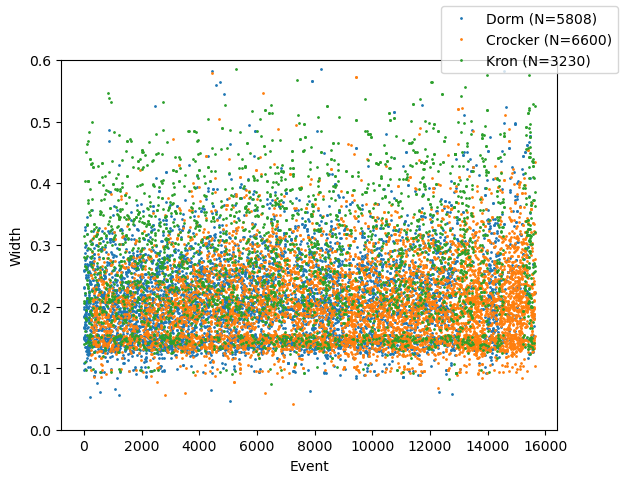

In [52]:
fig,axs = plt.subplots()
plt.xlabel('Event')
plt.ylabel('Width')
# select subset of showers which are nearby
# array = array[np.hypot(array["TrueXcore"].values,array["TrueYcore"].values) < 200]

# cut showers by distance
# array = array[array["Distance"].values < 3]

# cut showers by alpha
# array = array[array["Alpha"].values < 0.3]

# cut showers by size
# array = array[array["Size"].values > 200]

# cut by number of telescopes
# minTel=3
# array = array.groupby('Event', group_keys=False).filter(lambda x: len(x) > (minTel-1))


telName = {
  1: "Kron",
  2: "Dorm",
  3: "Crocker"
}

colormap = iter(cm.tab10(np.linspace(0, 1, 10)))
for t in [2,3,1]:#range(3,0,-1):
    # filter by telescope
    telescope = array[array["Telescope"].values == t]
    
    #plot 
    c=next(colormap)
    a=1
    axs.plot(telescope.Event,telescope.Width, linestyle='None', markersize=1, marker='o', color=c, alpha=a,label=telName[t]+" (N={:.0f})".format(len(telescope)))

# axs.set_xlim(0,1)
axs.set_ylim(0,0.6)

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels)


(0.0, 4000.0)

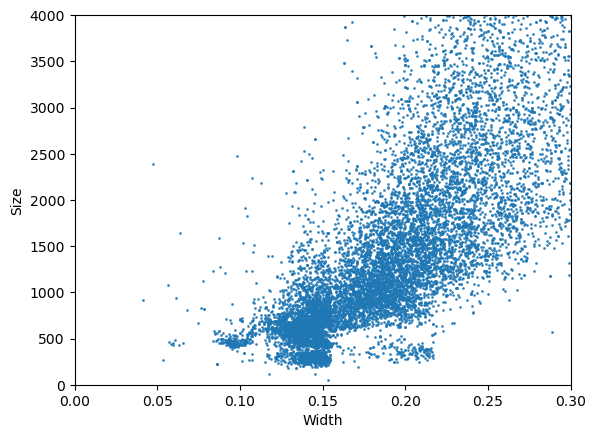

In [53]:
width=array["Width"]
dist=array["Distance"]
size=array["Size"]
fig,axs = plt.subplots()
plt.xlabel('Width')
plt.ylabel('Size')
axs.plot(width,size,linestyle='None',alpha=0.8,marker='o',markersize=1)
axs.set_xlim(0,0.3)
axs.set_ylim(0,4000)


In [54]:
# fig,axs = plt.subplots()
# plt.xlabel('Shower Core Distance to Telescope (m)')
# plt.ylabel('Width')
# axs.plot(r,width,linestyle='None',alpha=0.2,marker='o',markersize=1)

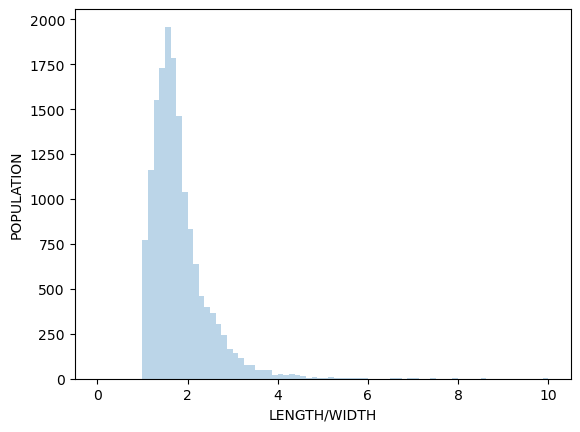

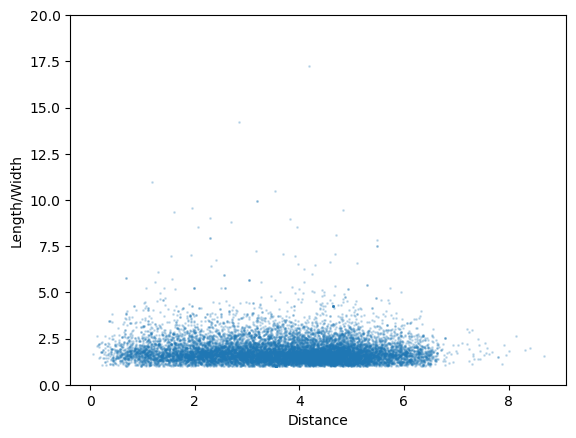

In [55]:
length=array["Length"]

fig, axs = plt.subplots()
plt.xlabel('LENGTH/WIDTH')
plt.ylabel('POPULATION')
axs.hist(array.loc[:,"Length"]/array.loc[:,"Width"], alpha=0.3, bins=80, range=(0,10))

fig,axs = plt.subplots()
plt.xlabel('Distance')
plt.ylabel('Length/Width')
plt.ylim(0,20)
axs.plot(dist,length/width,linestyle='None',alpha=0.2,marker='o',markersize=1)

## Per Telescope

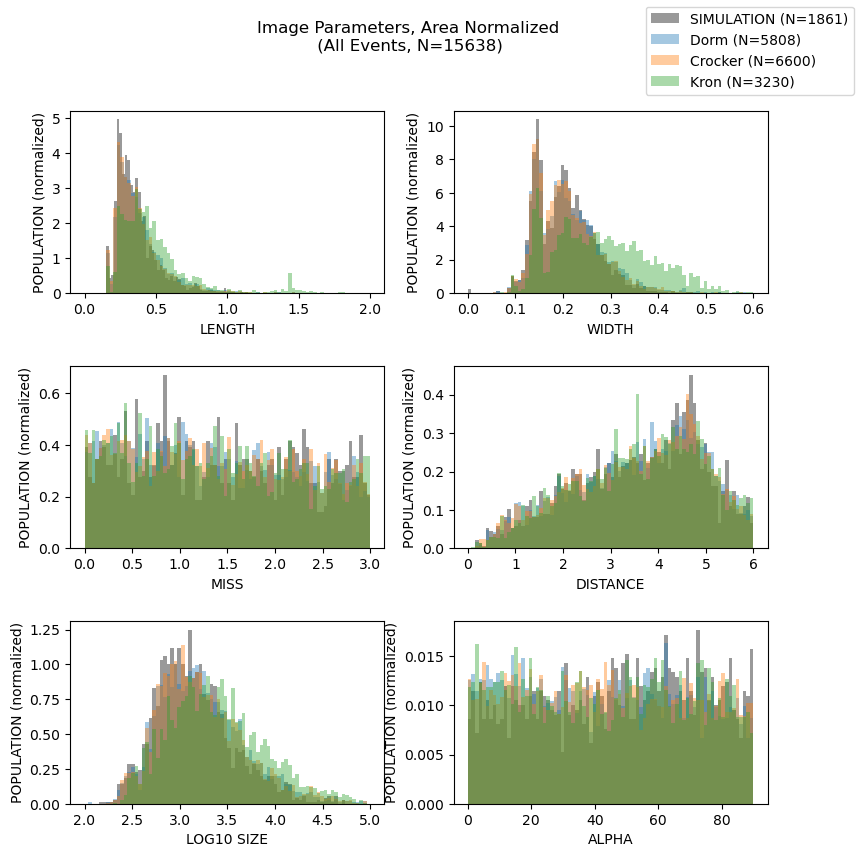

In [56]:
fig, axs = plt.subplots(3,2, figsize=(9,9))
plt.subplots_adjust(hspace=0.4, wspace=0.22)

# select subset of showers which are nearby
# array = array[np.hypot(array["TrueXcore"].values,array["TrueYcore"].values) < 200]

# cut showers by distance
# array = array[array["Distance"].values < 3]

# cut showers by alpha
# array = array[array["Alpha"].values < 0.3]

# cut showers by size
# array = array[array["Size"].values > 200]

# cut by number of telescopes
# minTel=3
# array = array.groupby('Event', group_keys=False).filter(lambda x: len(x) > (minTel-1))


fig.suptitle('Image Parameters, Area Normalized'+'\n (All Events, N={:.0f})'.format(len(array)))


telName = {
  1: "Kron",
  2: "Dorm",
  3: "Crocker"
}

# # #
# SIMS (PROTON)
# # #
# simfiles = glob.glob("tmp/**/_merged.csv",recursive=True)
# simfiles = sorted(simfiles[:-1]) #exclude gamma
# combined_df = pd.DataFrame()
# for csv_file in simfiles:
#     sim_df = pd.read_csv(csv_file)
#     combined_df = pd.concat([combined_df, sim_df])
# combined_df=pd.read_csv("../../corsika/data/lick2024/MRK421-sim-proton/data/_merged.csv")
# sims=combined_df.dropna(subset=["Length", "Width","Miss","Distance","Azwidth","Alpha"])
# sims=sims[sims["Width"]>0]
# sims = sims.groupby('Event', group_keys=False).filter(lambda x: len(x) > (minTel-1))

###
# CUTS
###

# array = array[array["Size"].values <= 400]
# sims = sims[sims["Size"].values <= 400]
a=0.4
axs[0,0].hist(sims.loc[:,"Length"], alpha=a, bins=b, range=(0,1.5),color='k',density=True,label='SIMULATION (N={:.0f})'.format(len(sims)))
axs[0,0].set(xlabel='LENGTH')
axs[0,1].hist(sims.loc[:,"Width"], alpha=a, bins=b, range=(0,0.6),color='k',density=True)
axs[0,1].set(xlabel='WIDTH')
axs[1,0].hist(sims.loc[:,"Miss"], alpha=a, bins=b, range=(0,3),color='k',density=True)
axs[1,0].set(xlabel='MISS')
axs[1,1].hist(sims.loc[:,"Distance"], alpha=a, bins=b, range=(0,6),color='k',density=True)
axs[1,1].set(xlabel='DISTANCE')
# axs[2,0].hist(sims.loc[:,"Azwidth"], alpha=a, bins=b, range=(0,1),color='k',density=True)
# axs[2,0].set(xlabel='AZWIDTH')
axs[2,0].hist(np.log10(sims.loc[:,"Size"]), alpha=a, bins=b, range=(2,5),color='k',density=True)
axs[2,0].set(xlabel='LOG10 SIZE')
# axs[2,0].hist(sims.loc[:,"Size"], alpha=a, bins=b, range=(0,1e3),color='k',density=True)
# axs[2,0].set(xlabel='SIZE')
axs[2,1].hist(sims.loc[:,"Alpha"], alpha=a, bins=b, range=(0,90),color='k',density=True)
axs[2,1].set(xlabel='ALPHA')


axs[0,0].set(xlabel='LENGTH')
axs[0,1].set(xlabel='WIDTH')
axs[1,0].set(xlabel='MISS')
axs[1,1].set(xlabel='DISTANCE')
# axs[2,0].set(xlabel='SIZE')
axs[2,0].set(xlabel='LOG10 SIZE')
axs[2,1].set(xlabel='ALPHA')
for ax in axs.flat:
        ax.set(ylabel='POPULATION (normalized)')

# size
# fig2,axs2 = plt.subplots()
colormap = iter(cm.tab10(np.linspace(0, 1, 10)))
for t in [2,3,1]:#range(3,0,-1):
    # filter by telescope
    telescope = array[array["Telescope"].values == t]
    
    #plot 
    c=next(colormap)
    a=0.4
    axs[0,0].hist(telescope.loc[:,"Length"], color=c, alpha=a, bins=80, range=(0,2),label=telName[t]+" (N={:.0f})".format(len(telescope)),density=True)
    axs[0,1].hist(telescope.loc[:,"Width"], color=c, alpha=a, bins=80, range=(0,0.6),label=telName[t],density=True)
    axs[1,0].hist(telescope.loc[:,"Miss"], color=c, alpha=a, bins=80, range=(0,3),label=telName[t],density=True)
    axs[1,1].hist(telescope.loc[:,"Distance"], color=c, alpha=a, bins=80, range=(0,6),label=telName[t],density=True)
    axs[2,0].hist(np.log10(telescope.loc[:,"Size"]), color=c, alpha=a, bins=80, range=(2,5),label=telName[t],density=True)
    # axs[2,0].hist(telescope.loc[:,"Size"], color=c, alpha=a, bins=80, range=(0,1e3),label=telName[t],density=True)
    axs[2,1].hist(telescope.loc[:,"Alpha"], color=c, alpha=a, bins=80, range=(0,90),label=telName[t],density=True)

    # axs2.set(xlabel='SIZE')
    # axs2.set(ylabel='POPULATION')
    # axs2.hist(telescope.loc[:,"Size"], color=c,alpha=a, bins=80,range=(0,1e4))

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels)
# fig2.legend(handles, labels,loc='upper right',bbox_to_anchor=(0.8,0.8 ))


    
    

# Per Quabo/Chip

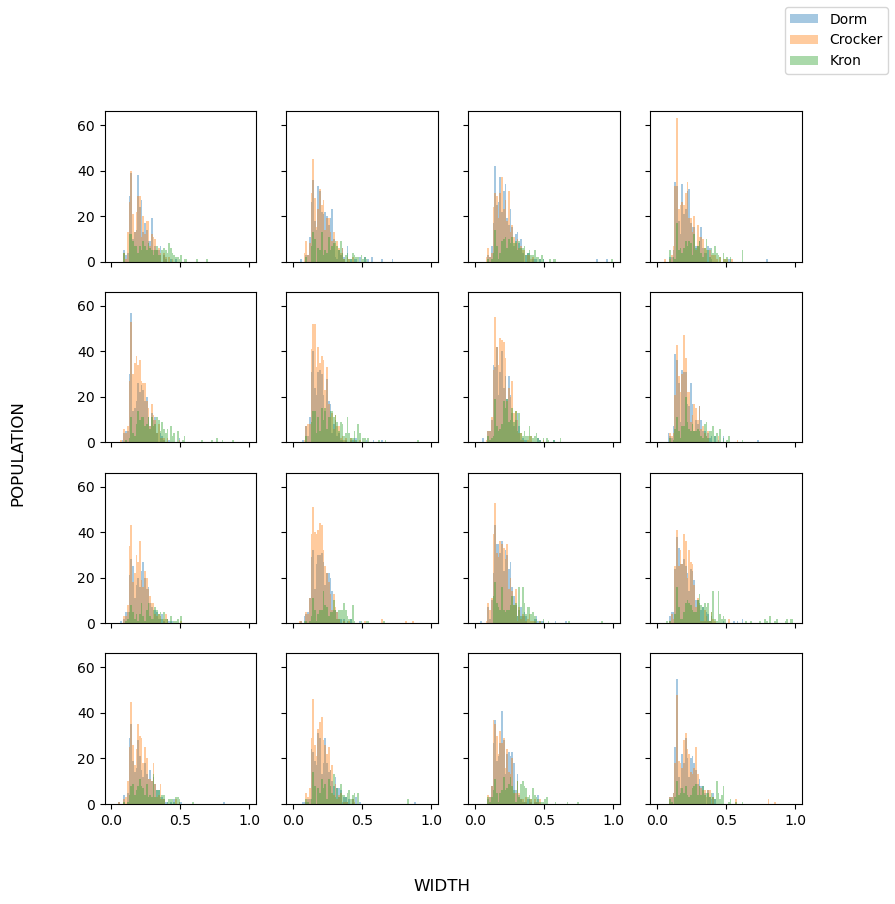

In [57]:
# chip = true for per chip, false for per quabo
chip=True

if chip:
  fig, axs = plt.subplots(4,4, figsize=(9,9),sharex=True,sharey=True)
  quabo = [(8*0.31*(i)-4.96, 8*0.31*((i+1))-4.96,8*0.31*(4-(j+1))-4.96,8*0.31*(4-j)-4.96) for j in range(4) for i in range(4)] 
else:
  fig, axs = plt.subplots(2,2, figsize=(9,9),sharex=True,sharey=True)
  quabo = [(16*0.31*(i)-4.96, 16*0.31*((i+1))-4.96,16*0.31*(2-(j+1))-4.96,16*0.31*(2-j)-4.96) for j in range(2) for i in range(2)] 

  

fig.supxlabel('WIDTH')
fig.supylabel('POPULATION')
plt.tight_layout

# select subset of showers which are nearby
# array = array[np.hypot(array["TrueXcore"].values,array["TrueYcore"].values) < 200]

# cut showers by distance
# array = array[array["Distance"].values < 3]

# cut showers by alpha
# array = array[array["Alpha"].values < 0.3]

# cut showers by size
# array = array[array["Size"].values > 200]

# cut by number of telescopes
# minTel=3
# array = array.groupby('Event', group_keys=False).filter(lambda x: len(x) > (minTel-1))


# fig.suptitle('Image Parameters'+'\n (All Events, N={:.0f})'.format(len(array)))


telName = {
  1: "Kron",
  2: "Dorm",
  3: "Crocker"
}

# From top left to bottom right

colormap = iter(cm.tab10(np.linspace(0, 1, 10)))
for t in [2,3,1]:#range(3,0,-1):
    # filter by telescope
    telescope = array[array["Telescope"].values == t]
    c=next(colormap)
    a=0.4
    n=0
    for j in range(4 if chip else 2):
        for i in range(4 if chip else 2):
          data=telescope[telescope["MeanX"]>quabo[n][0]]
          data=data[data["MeanX"]<quabo[n][1]]
          data=data[data["MeanY"]>quabo[n][2]]
          data=data[data["MeanY"]<quabo[n][3]]
          axs[i,j].hist(data.loc[:,"Width"], color=c, alpha=a, bins=80, range=(0,1),label=telName[t])
          n=n+1

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels)


    

In [58]:
data.describe()

,Event,Telescope,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,Miss,Distance,Azwidth,Alpha,In-file-Index
count,165.000000,165.0,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,6589.424242,1.0,3.663792,0.395320,-3.680542,0.395479,197.756511,5628.521212,0.479184,0.303368,3.316682,5.240789,0.399716,42.951174,1052.709091
std,4563.995535,0.0,0.677938,0.150871,0.662027,0.166933,138.727678,10493.459212,0.169098,0.114068,1.638677,0.631456,0.156902,23.361756,1017.625183
min,49.000000,1.0,2.506348,0.149411,-4.928662,0.138692,0.206668,251.000000,0.159865,0.093881,0.098155,3.789576,0.107391,1.079602,8.000000
25%,2604.000000,1.0,3.074998,0.290231,-4.231901,0.264165,46.377550,1253.000000,0.352883,0.202236,1.854270,4.818608,0.291357,21.493495,414.000000
50%,6311.000000,1.0,3.726355,0.388039,-3.764393,0.378051,280.754348,2933.000000,0.470938,0.291871,3.591885,5.209535,0.365348,44.659504,838.000000
75%,9838.000000,1.0,4.233696,0.476736,-3.102983,0.516120,322.366785,6423.000000,0.572844,0.391264,4.652984,5.725563,0.471531,59.576424,1165.000000
max,15634.000000,1.0,4.873748,1.024618,-2.487834,0.799801,359.786343,116573.000000,1.144649,0.615877,5.934914,6.515812,1.099100,88.350887,5686.000000


# Plot Centroids

## combined

Kron mean: (-0.38,-0.15)
Dorm mean: (-0.05,-0.16)
Crocker mean: (0.00,0.00)


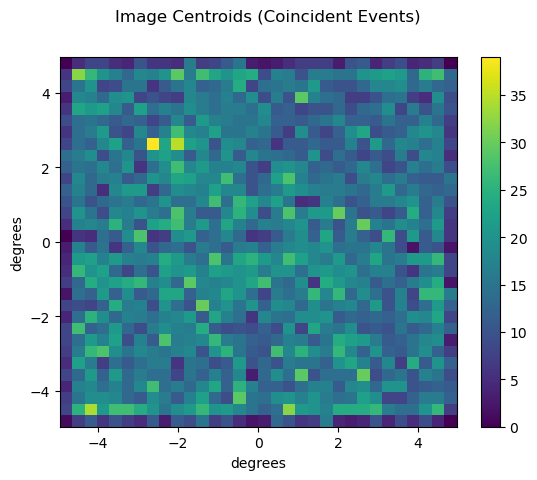

In [59]:
telName = {
  1: "Kron",
  2: "Dorm",
  3: "Crocker"
}

fig,ax = plt.subplots()
plt.xlim(-4.96,4.96)
plt.ylim(-4.96,4.96)
fig.suptitle('Image Centroids (Coincident Events)',x=0.45)

# colormap = iter(cm.tab10(np.linspace(0, 1, 10)))
x_all = array.loc[:,"MeanX"]
y_all = array.loc[:,"MeanY"]
for t in range(1,4):
    # filter by telescope
    telescope = array[array["Telescope"].values == t]

    #plot 
    x=telescope.loc[:,"MeanX"]
    y=telescope.loc[:,"MeanY"]
    xerr=telescope.loc[:,"StdX"]
    yerr=telescope.loc[:,"StdX"]
    r=np.sqrt(xerr*xerr+yerr*yerr)
    # c=next(colormap)
    
    # for a,b,q in zip(x, y, r):
    #   circle = plt.Circle((a,b), q, color=c, fill=True, alpha=0.02)
    #   ax.add_patch(circle)

    # ax.scatter(x.values,y.values,s=np.pi*r.values*r.values, alpha=0.3,color=c, label=telName[t]+" (N={:.0f})".format(len(telescope)))

    #ax.scatter(np.mean(x.values),np.mean(y.values),s=80,marker='x',color=c,label=telName[t]+" mean")
    ax.set(xlabel='degrees',ylabel='degrees')
    print(telName[t]+" mean: "+"({:.2f},{:.2f})".format(np.mean(x.values),np.mean(y.values)))

hist=ax.hist2d(x_all,y_all,bins=32,range=[[-4.96,4.96],[-4.96,4.96]])
#handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels)
fig.colorbar(hist[3], ax=ax)

## individual

Kron mean: (-0.38,-0.15)
Dorm mean: (-0.05,-0.16)
Crocker mean: (0.00,0.00)


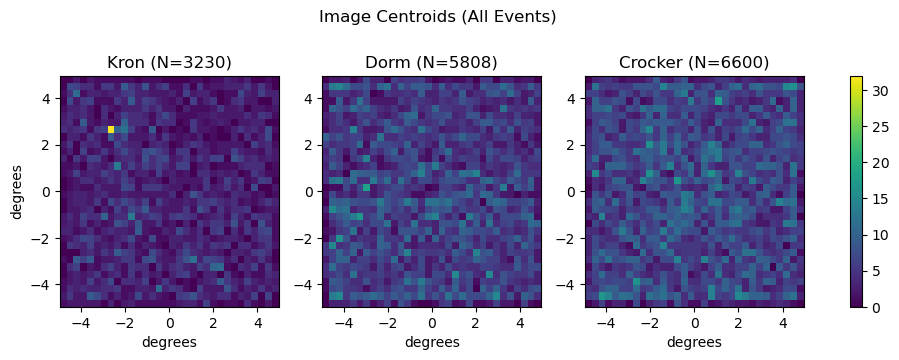

In [60]:
telName = {
  1: "Kron",
  2: "Dorm",
  3: "Crocker"
}
fig,axs = plt.subplots(1,3,figsize=(12,3))
fig.suptitle('Image Centroids (All Events)',x=0.44,y=1.1)
# colormap = iter(cm.tab10(np.linspace(0, 1, 10)))
vmax=0
hist=[0,0,0]
for t in range(1,4):
  plt.xlim(-4.96,4.96)
  plt.ylim(-4.96,4.96)
  # filter by telescope
  telescope = array[array["Telescope"].values == t]

  #plot 
  x=telescope.loc[:,"MeanX"]
  y=telescope.loc[:,"MeanY"]
  xerr=telescope.loc[:,"StdX"]
  yerr=telescope.loc[:,"StdX"]
  r=np.sqrt(xerr*xerr+yerr*yerr)
  # c=next(colormap)

  # for a,b,q in zip(x, y, r):
  #   circle = plt.Circle((a,b), q, color=c, fill=True, alpha=0.02)
  #   axs[t-1].add_patch(circle)

  # axs[t-1].scatter(x.values,y.values,s=np.pi*r.values*r.values, color=c, alpha=0.3, label=telName[t]+" (N={:.0f})".format(len(telescope)))\
  hist[t-1]=axs[t-1].hist2d(x.values,y.values,bins=32,range=[[-4.96,4.96],[-4.96,4.96]])
  #axs[t-1].scatter(np.mean(x.values),np.mean(y.values),s=80,marker='x',color=c,label=telName[t]+" mean")
  print(telName[t]+" mean: "+"({:.2f},{:.2f})".format(np.mean(x.values),np.mean(y.values)))
  axs[t-1].set(title=telName[t]+" (N={:.0f})".format(len(telescope)))
  vmax=max(vmax,np.nanmax(hist[t-1][0]))

for h in hist:
  h[3].set_clim(0,vmax)

axs[0].set(xlabel='degrees',ylabel='degrees')
axs[1].set(xlabel='degrees')
axs[2].set(xlabel='degrees')
# handles, labels = axs.get_legend_handles_labels()
#fig.legend(loc='upper center',bbox_to_anchor=(0.5, 1.2));
fig.colorbar(hist[2][3], ax=axs)

### animate

In [61]:
# from matplotlib.animation import FuncAnimation

# telName = {
#   1: "Kron",
#   2: "Dorm",
#   3: "Crocker"
# }

# # calculate offset based on approximate drift velocity
#     # assumes linear drift velocity
# # time_start, time_end in minutes
# def calc_offset(telescope,event,pix_start,pix_end,time_start,time_end):

#     # get time (approximate)
#     t = telescope.loc[:, "File"].values[event]
#     t = 60*int(t[9:-8])+int(t[11:-6])+int(t[13:-4])/60 # file string to time in minutes
    
#     vx=(pix_end[0]-pix_start[0]) / (time_end-time_start)
#     vy=(pix_end[1]-pix_start[1]) / (time_end-time_start)

#     x=(t-time_start)*vx
#     y=(t-time_start)*vy

#     return (x,y)


# # apply correction
# def correct_pointing(telescope):
#     x = []
#     y = []
#     for event in range(0,len(telescope)):

#         # before meridian flip
#         if(telescope.iloc[event]["In-file-Index"]<=1813):
#             correction = {
#                 1: (3, 1),
#                 2: (0, 0),
#                 3: calc_offset(telescope,event,[-14,-16],[-21,-15],311,441)
#             }

#         # after meridian flip
#         else:
#             correction = {
#                 1: (-2, 3),
#                 2: (0, 0),
#                 3: calc_offset(telescope,event,[13.5,14],[18,13.5],461,541)
#             }
            
#         c = correction[telescope.loc[:,'Telescope'].values[event]]
#         # mult by 0.3 to go from pixel to degrees
#         x.append(telescope.loc[:, "MeanX"].values[event] - 0.3*c[0])
#         y.append(telescope.loc[:, "MeanY"].values[event] - 0.3*c[1])
        
#     return x,y



# fig,axs = plt.subplots(1,3,figsize=(12,3))
# fig.suptitle('Image Centroids (Coincident Events)',x=0.44,y=1.1)
# hist = [ax.hist2d([], [], bins=32, range=[[-4.96, 4.96], [-4.96, 4.96]]) for ax in axs]
# cbar = fig.colorbar(hist[0][3], ax=axs)

# def update(frame):
#     # Clear the previous plot
#     for ax in axs:
#         ax.cla()

#     # Plot the updated data for each telescope
#     vmax = 6 #fixed scale
#     # vmax = 0 #dynamic scale update
#     for t in range(1, 4):
#         telescope = array[array["Telescope"].values == t]
#         # x = telescope.loc[:, "MeanX"]
#         # y = telescope.loc[:, "MeanY"]
#         x,y = correct_pointing(telescope)
#         start = frame-60 if (frame-60>=0) else 0
#         end = frame+60 if (frame+60<len(telescope)) else len(telescope)
#         hist[t-1]=axs[t-1].hist2d(x[start:end],y[start:end], bins=32,range=[[-4.96,4.96],[-4.96,4.96]])
#         axs[t-1].scatter(np.mean(x[start:end]),np.mean(y[start:end]),color='white',s=36,marker='x')
#         axs[t-1].set(title=telName[t])
#         vmax = max(vmax, np.nanmax(hist[t - 1][0]))
#         # hist[t-1]=axs[t-1].hist2d(x.values[start:end], y.values[start:end], bins=32,range=[[-4.96,4.96],[-4.96,4.96]])
#         # axs[t-1].scatter(np.mean(x.values[start:end]),np.mean(y.values[start:end]),color='white',s=36,marker='x')
#         # axs[t-1].set(title=telName[t])
#         # vmax = max(vmax, np.nanmax(hist[t - 1][0]))


#     # Set common properties
#     axs[0].set(xlabel='degrees', ylabel='degrees')
#     axs[1].set(xlabel='degrees')
#     axs[2].set(xlabel='degrees')

#     for h in hist:
#         h[3].set_clim(0,vmax)    

#     cbar.mappable.set_clim(0, vmax)
    
# ani = FuncAnimation(fig, update, frames=len(telescope), interval=34, repeat=False)
# ani.save('centroids_corrected_animated.mp4',writer='ffmpeg')